This code was adapted from the tutorial here: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


# Hyperparameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# data_dir = '/content/drive/My Drive/Semester 5/COS 429/COS429_Final/fitzpatrick17k-main/images/labels9_augmented'
# for Katie's:
data_dir = '/content/drive/My Drive/COS429_Final/fitzpatrick17k-main/images/labels3'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training the Model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  # Get model outputs and calculate loss
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)

                  _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize the model

In [ ]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    """ Resnet18
    """
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Normalize and crop the data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model_ft.cuda()
print()
print("Running on", device)

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Running on cuda:0


# Optimize the model by only training the new layers

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# save the model for later use
# untrained_model_path = '/content/drive/My Drive/Semester 5/COS 429/COS429_Final/single_cnn'
untrained_model_path = '/content/drive/My Drive/COS429_Final/single_cnn'
torch.save(model_ft, untrained_model_path)

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

# save the model for later use
# model_path = '/content/drive/My Drive/Semester 5/COS 429/COS429_Final/single_cnn_trained'
model_path = '/content/drive/My Drive/COS429_Final/single_cnn_trained'
torch.save(model_ft, model_path)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7199 Acc: 0.7391
val Loss: 0.6608 Acc: 0.7674

Epoch 1/14
----------
train Loss: 0.6954 Acc: 0.7436
val Loss: 0.6719 Acc: 0.7732

Epoch 2/14
----------
train Loss: 0.6734 Acc: 0.7524
val Loss: 0.5989 Acc: 0.7845

Epoch 3/14
----------
train Loss: 0.6516 Acc: 0.7630
val Loss: 0.6354 Acc: 0.7923

Epoch 4/14
----------
train Loss: 0.6428 Acc: 0.7631
val Loss: 0.5838 Acc: 0.7898

Epoch 5/14
----------
train Loss: 0.6196 Acc: 0.7718
val Loss: 0.5794 Acc: 0.7968

Epoch 6/14
----------
train Loss: 0.6109 Acc: 0.7691
val Loss: 0.6018 Acc: 0.7697

Epoch 7/14
----------
train Loss: 0.6120 Acc: 0.7712
val Loss: 0.5773 Acc: 0.8066

Epoch 8/14
----------
train Loss: 0.5919 Acc: 0.7808
val Loss: 0.6236 Acc: 0.7757

Epoch 9/14
----------
train Loss: 0.5924 Acc: 0.7848
val Loss: 0.5743 Acc: 0.7910

Epoch 10/14
----------
train Loss: 0.5879 Acc: 0.7822
val Loss: 0.6227 Acc: 0.7867

Epoch 11/14
----------
train Loss: 0.5785 Acc: 0.7877
val Loss: 0.5533 Acc: 0.8078

Epoch 12/14
----------
t

# Evaluate the Model

In [ ]:
device = torch.device("cpu")
print("Running on", device)
print()

# Load the trained model from file
#model_ft_path = '/content/drive/My Drive/Semester 5/COS 429/COS429_Final/single_cnn_trained'
#model_ut_path = '/content/drive/My Drive/Semester 5/COS 429/COS429_Final/single_cnn'
model_ft_path = '/content/drive/My Drive/COS429_Final/single_cnn_trained'
model_ut_path = '/content/drive/My Drive/COS429_Final/single_cnn'
model_ft = torch.load(model_ft_path)
model_ft.to(device)

model_ut = torch.load(model_ut_path)
model_ut.to(device)

#data_dir = '/content/drive/My Drive/Semester 5/COS 429/COS429_Final/fitzpatrick17k-main/images/fitz3'
data_dir = '/content/drive/My Drive/COS429_Final/fitzpatrick17k-main/images/fitz3'

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms['val']) for x in ['1','2','3','4','5','6']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, num_workers=4) for x in ['1','2','3','4','5','6']}


val_acc_history = []

num_fitz_labels = 7

model_ut.eval()
model_ft.eval()

Running on cpu



KeyboardInterrupt: ignored

In [ ]:
since = time.time()

for label in ['1','2','3','4','5','6']:
    print('label {}/{}'.format(label, num_fitz_labels - 1))
    print('-' * 10)
    running_loss_ft = 0.0
    running_corrects_ft = 0
    running_loss_ut = 0.0
    running_corrects_ut = 0

    # Iterate over data.
    for inputs, labels in dataloaders_dict[label]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_ft.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs_ft = model_ft(inputs)
            loss_ft = criterion(outputs_ft, labels)
            _, preds_ft = torch.max(outputs_ft, 1)

            outputs_ut = model_ut(inputs)
            loss_ut = criterion(outputs_ut, labels)
            _, preds_ut = torch.max(outputs_ut, 1)

        # statistics
        running_loss_ft += loss_ft.item() * inputs.size(0)
        running_corrects_ft += torch.sum(preds_ft == labels.data)

        running_loss_ut += loss_ut.item() * inputs.size(0)
        running_corrects_ut += torch.sum(preds_ut == labels.data)

    label_loss_ft = running_loss_ft / len(dataloaders_dict[label].dataset)
    label_acc_ft = running_corrects_ft.double() / len(dataloaders_dict[label].dataset)

    label_loss_ut = running_loss_ut / len(dataloaders_dict[label].dataset)
    label_acc_ut = running_corrects_ut.double() / len(dataloaders_dict[label].dataset)

    print('Trained Loss: {:.4f} Acc: {:.4f}'.format(label_loss_ft, label_acc_ft))
    print('Untrained Loss: {:.4f} Acc: {:.4f}'.format(label_loss_ut, label_acc_ut)) 
    print('Difference in Loss: {:.4f} Acc: {:.4f}'.format((label_loss_ft - label_loss_ut), (label_acc_ft - label_acc_ut)))   
    print()

time_elapsed = time.time() - since
print('Evaluation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

label 1/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Trained Loss: 0.9704 Acc: 0.7521
Untrained Loss: 2.4419 Acc: 0.0602
Difference in Loss: -1.4715 Acc: 0.6919

label 2/6
----------
Trained Loss: 0.9512 Acc: 0.7389
Untrained Loss: 2.4782 Acc: 0.0634
Difference in Loss: -1.5270 Acc: 0.6755

label 3/6
----------
Trained Loss: 0.8896 Acc: 0.7503
Untrained Loss: 2.4783 Acc: 0.0433
Difference in Loss: -1.5887 Acc: 0.7070

label 4/6
----------
Trained Loss: 0.8901 Acc: 0.7749
Untrained Loss: 2.4684 Acc: 0.0459
Difference in Loss: -1.5783 Acc: 0.7289

label 5/6
----------
Trained Loss: 0.9480 Acc: 0.7682
Untrained Loss: 2.4854 Acc: 0.0539
Difference in Loss: -1.5374 Acc: 0.7143

label 6/6
----------
Trained Loss: 0.8052 Acc: 0.7785
Untrained Loss: 2.5829 Acc: 0.0201
Difference in Loss: -1.7777 Acc: 0.7584

Evaluation complete in 11m 58s


# Confusion Matrix

In [ ]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[ 203.,   19.,  330.],
        [  64.,  233.,  235.],
        [  56.,   39., 2802.]])


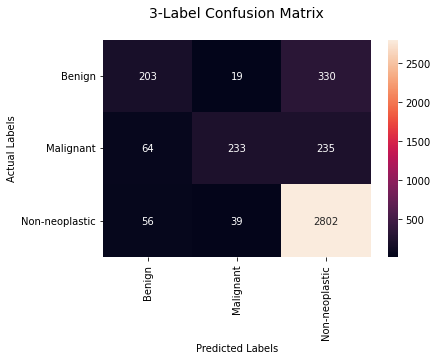

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(confusion_matrix.cpu().detach().numpy(), annot=True, fmt='g');

## Modify the Axes Object directly to set various attributes such as the
## Title, X/Y Labels.
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels');

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['Benign', 'Malignant', 'Non-neoplastic'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant', 'Non-neoplastic'])
#ax.xaxis.set_ticklabels(['B. Dermal', 'B. Epiderm', 'B. Melanocyte', 'Genoderm',
#                         'Inflam', 'M. Cutaneous', 'M. Dermal', 'M Epiderm', 
#                         'M. Melanoma'])
#ax.yaxis.set_ticklabels(['B. Dermal', 'B. Epiderm', 'B. Melanocyte', 'Genoderm',
#                         'Inflam', 'M. Cutaneous', 'M. Dermal', 'M Epiderm', 
#                         'M. Melanoma'])

## Finally call the matplotlib show() function to display the visualization
## of the Confusion Matrix.
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 


plt.title('3-Label Confusion Matrix\n', fontdict={'fontsize':14})
plt.show()

In [ ]:
import glob
print(len(glob.glob('drive/My Drive/COS429_Final/fitzpatrick17k-main/images/labels3/val/benign/*.jpg')))
print(len(glob.glob('drive/My Drive/COS429_Final/fitzpatrick17k-main/images/labels3/val/malignant/*.jpg')))
print(len(glob.glob('drive/My Drive/COS429_Final/fitzpatrick17k-main/images/labels3/val/non-neoplastic/*.jpg')))

552
532
653


In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
